### 스마트폴 데이터 전처리 기준

#### 1. 공영주차장: 주차면적 5이상만 고려
#### 2. 충전소 리스트: 제한없음
#### 3. 공영주차장 충전소 리스트: 충전소 중에서도 공영주차장에 세워진 충전소만 고려
#### 4. 환경부크롤링데이터: 전체적인 데이터도 있지만 그중에서도 사용중인 충전소에 초점
#### 5. 타기관크롤링데이터: 전체적인 데이터도 있지만 그중에서도 급속이고, 사용중인 충전소에 초점
#### 6. 교통량: 업무지 위주의 충전소를 원하는 전기차 수요층 및 구매자 조사를 고려, 7시와 15시에 초점
#### 7. 인구데이터: 업무지 위주의 충전소를 원하는 전기차 수요층 및 구매자 조사를 고려, 9시에 초점
#### 8. 전기차 등록현황: 제한없음
#### 9. 서울 노드+링크: 제한없음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager,rc 
import folium
import json
#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
#- 값 깨짐 방지
matplotlib.rcParams['axes.unicode_minus']=False

%matplotlib inline

# 데이터 불러오기 (구별 상관계수를 위한)

In [2]:
#현재 공영주차장에 지어진 충전소 리스트 
already= pd.read_csv('data/공영주차장 충전소 리스트')
already.head()

,name,address,area,group,dong
0,대청역 공영주차장,서울특별시 강남구 개포동 13-2,강남구,동남권,개포동
1,논현로22길 공영주차장,서울특별시 강남구 개포로 25길 32,강남구,동남권,개포동
2,개포동공원 공영주차장,"서울특별시 강남구 개포로 509, 지하주차장 1층 8구역(개포동 183-2)",강남구,동남권,개포동
3,학여울역 공영주차장,"서울특별시 강남구 남부순환로 3104, 지하주차장 3층 M418구역(대치동 514)",강남구,동남권,대치동
4,서울시 학여울역공영주차장(급속),서울특별시 강남구 남부순환로 지하 3104학여울역 공영주차장 지하3층 6기둥(514...,강남구,동남권,대치동


In [3]:
# 비교를 위해 아직 지어지지않은 공영주차장(우리의 후보 주차장) 데이터가져옴
park=pd.read_csv('data/최종후보공영주차장.csv',encoding='cp949')
park.head()

,name,address,type,gu,dong,group,park_space,lat,lon
0,구룡산제2호(구),강남구 개포동 126-2,노외 주차장,강남구,개포동,동남권,132,37.477319,127.066489
1,논현로22길(시),강남구 개포동 1266-0,노외 주차장,강남구,개포동,동남권,97,37.481443,127.048030
2,포이초교 공영주차장(구),강남구 개포동 1273-0,노외 주차장,강남구,개포동,동남권,194,37.475602,127.052321
3,개포동공원 공영주차장(구),강남구 개포동 183-2,노외 주차장,강남구,개포동,동남권,149,37.489490,127.066202
4,개포주공5단지북측(구),강남구 개포동 186-6,노상 주차장,강남구,개포동,동남권,64,37.488804,127.068359


In [4]:
park['name'].duplicated().sum()

0

In [5]:
#전체 충전소 리스트
total=pd.read_csv('data/충전소 리스트.csv')
total=total.drop_duplicates(subset='address',keep='first')
total.head()

,address,lon,lat,dong,gu,group
0,서울특별시 강남구 강남대로 128길 20 영동프라자,127.023835,37.509998,논현동,강남구,동남권
1,서울특별시 강남구 강남대로 298 (역삼동)지하8층 E기둥,127.032169,37.490054,역삼동,강남구,동남권
2,서울특별시 강남구 강남대로120길 33,127.026244,37.508270,논현동,강남구,동남권
3,서울특별시 강남구 강남대로146길 28105동 지하3층 17번,127.023095,37.515587,논현동,강남구,동남권
4,서울특별시 강남구 강남대로84길 33대우디오빌플러스,127.031066,37.497524,역삼동,강남구,동남권


In [6]:
total['address'].duplicated().sum()

0

In [7]:
car=pd.read_csv('data/전기차등록현황.csv')
car=car[['사용본거지법정동명','전기','구','동']]
car=car.fillna(0.0)
car.head()

,사용본거지법정동명,전기,구,동
0,서울특별시 종로구 청운동,4.0,종로구,청운동
1,서울특별시 종로구 신교동,3.0,종로구,신교동
2,서울특별시 종로구 궁정동,0.0,종로구,궁정동
3,서울특별시 종로구 효자동,1.0,종로구,효자동
4,서울특별시 종로구 창성동,1.0,종로구,창성동


In [8]:
h_0813=pd.read_csv('data/210813')
h_0813.head()

,gu,개수
0,강남구,38
1,강동구,7
2,강북구,6
3,강서구,50
4,관악구,17


In [9]:
h_0817=pd.read_csv('data/210817')
h_0817.head()

,gu,개수
0,강남구,29
1,강동구,7
2,강북구,5
3,강서구,48
4,관악구,15


In [10]:
h_0818=pd.read_csv('data/210818')
h_0818.head()

,gu,개수
0,강남구,19
1,강동구,6
2,강북구,4
3,강서구,38
4,관악구,6


In [11]:
h_0820=pd.read_csv('data/210820')
h_0820.head()

,gu,개수
0,강남구,14
1,강동구,9
2,강북구,6
3,강서구,29
4,관악구,8


In [12]:
t_0823=pd.read_csv('data/210823 타기관.csv')
t_0823.head()

,구명,개수
0,송파구,52
1,도봉구,36
2,은평구,22
3,양천구,22
4,중랑구,21


In [13]:
t_0824=pd.read_csv('data/210824 타기관.csv')
t_0824.head()

,구명,개수
0,송파구,58
1,도봉구,47
2,강남구,42
3,관악구,33
4,양천구,23


In [14]:
t_0826=pd.read_csv('data/210826 타기관 구별.csv')
t_0826.head()

,구명,개수
0,송파구,42
1,도봉구,37
2,강남구,27
3,강동구,26
4,중랑구,24


In [15]:
t_0827=pd.read_csv('data/210827 타기관 구별.csv')
t_0827.head()

,구명,개수
0,송파구,48
1,강남구,31
2,도봉구,25
3,관악구,24
4,영등포구,22


In [16]:
traffic1=pd.read_csv('data/교통량_7시(법정동).csv',encoding='cp949')
traffic1.columns=(['구','동','교통량'])
traffic1.head()

,구,동,교통량
0,강남구,개포동,172388.5
1,강남구,논현동,321848.0
2,강남구,대치동,350008.0
3,강남구,도곡동,203038.0
4,강남구,삼성동,299292.0


In [17]:
traffic2=pd.read_csv('data/교통량_15시(법정동).csv',encoding='cp949')
traffic2.columns=(['구','동','교통량'])
traffic2.head()

,구,동,교통량
0,강남구,개포동,160417.0
1,강남구,논현동,311693.0
2,강남구,대치동,337874.0
3,강남구,도곡동,188890.0
4,강남구,삼성동,299274.0


In [18]:
people=pd.read_csv('data/구별 인구데이터.csv')
people.head()

,구,합계
0,강남구,2.112358e+07
1,강동구,1.050674e+07
2,강북구,5.955376e+06
3,강서구,1.214517e+07
4,관악구,1.049358e+07


## 불러온 데이터 전처리

In [19]:
#환경부 크롤링 데이터 , 타기관 크롤링데이터
h0813_data=list(h_0813['개수'])
h0817_data=list(h_0817['개수'])
h0818_data=list(h_0818['개수'])
h0820_data=list(h_0820['개수'])
t0823_data=list(t_0823['개수'])
t0824_data=list(t_0824['개수'])
t0826_data=list(t_0826['개수'])
t0827_data=list(t_0827['개수'])

In [20]:
# 전기차 등록현황 데이터 => 전체 데이터에서 구별 개수 구하기 위해
for i in list(park["gu"].value_counts().index.sort_values()):
    temp=car.loc[car['구']==i,'전기']
    temp=temp.astype(int)
    print(i,temp.sum())

강남구 7490
강동구 657
강북구 302
강서구 839
관악구 413
광진구 300
구로구 1016
금천구 434
노원구 488
도봉구 353
동대문구 313
동작구 392
마포구 579
서대문구 377
서초구 2059
성동구 954
성북구 535
송파구 1084
양천구 546
영등포구 1943
용산구 475
은평구 490
종로구 281
중구 707
중랑구 414


In [21]:
#구 정보는 제외한 개수만 가져온다
car_data=[]
for i in list(park["gu"].value_counts().index.sort_values()):
    temp=car.loc[car['구']==i,'전기']
    temp=temp.astype(int)
    car_data.append(temp.sum())
car_data

[7490,
 657,
 302,
 839,
 413,
 300,
 1016,
 434,
 488,
 353,
 313,
 392,
 579,
 377,
 2059,
 954,
 535,
 1084,
 546,
 1943,
 475,
 490,
 281,
 707,
 414]

In [22]:
# 교통량 7시 데이터 => 전체 데이터에서 구별 개수 구하기 위해
for i in list(park["gu"].value_counts().index.sort_values()):
    temp2=traffic1.loc[traffic1['구']==i,'교통량']
    temp2=temp2.astype(int)
    print(i,temp2.sum())

강남구 2659676
강동구 917964
강북구 452893
강서구 1300629
관악구 963254
광진구 703450
구로구 1236942
금천구 620692
노원구 1320885
도봉구 459568
동대문구 865136
동작구 835823
마포구 1386261
서대문구 628491
서초구 2329446
성동구 892265
성북구 854201
송파구 1921661
양천구 1156197
영등포구 1885055
용산구 1148550
은평구 682164
종로구 797656
중구 877106
중랑구 558909


In [23]:
#구 정보는 제외한 개수만 가져온다
traffic_data1=[]
for i in list(park["gu"].value_counts().index.sort_values()):
    temp2=traffic1.loc[traffic1['구']==i,'교통량']
    temp2=temp2.astype(int)
    traffic_data1.append(temp2.sum())
traffic_data1

[2659676,
 917964,
 452893,
 1300629,
 963254,
 703450,
 1236942,
 620692,
 1320885,
 459568,
 865136,
 835823,
 1386261,
 628491,
 2329446,
 892265,
 854201,
 1921661,
 1156197,
 1885055,
 1148550,
 682164,
 797656,
 877106,
 558909]

In [24]:
# 교통량 15시 데이터 => 구 정보는 제외한 개수만 가져온다
traffic_data2=[]
for i in list(park["gu"].value_counts().index.sort_values()):
    temp3=traffic2.loc[traffic2['구']==i,'교통량']
    temp3=temp3.astype(int)
    traffic_data2.append(temp3.sum())
traffic_data2

[2571792,
 898177,
 438128,
 1206927,
 844226,
 694321,
 1105303,
 543514,
 1288810,
 448506,
 860974,
 755771,
 1317030,
 609431,
 2144917,
 874566,
 834145,
 1559774,
 1070166,
 1754486,
 1076845,
 652912,
 766150,
 848545,
 567250]

In [25]:
# 구는 25개로 어느데이터나 모두 동일하기때문에 park에서 구정보가져오고 대신 가나다순 정렬
park["gu"].value_counts().index.sort_values()

Index(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
       '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
       '용산구', '은평구', '종로구', '중구', '중랑구'],
      dtype='object')

In [26]:
#공영주차장 데이터, 기존에 공영주차장에 세워진 충전소데이터, 충전소 데이터 => 구별(가나다순)로 value_counts 개수만 구함
gu_list=list(park["gu"].value_counts().index.sort_values())
already_data=[]
park_data=[]
total_data=[]

for i in gu_list:
    park_data.append(park['gu'].value_counts()[i])
    already_data.append(already['area'].value_counts()[i])
    total_data.append(total['gu'].value_counts()[i])

print(park_data,len(park_data))
print(already_data,len(already_data))
print(total_data,len(total_data))

[59, 22, 35, 46, 19, 21, 26, 39, 25, 16, 33, 19, 33, 8, 31, 44, 12, 43, 56, 80, 30, 14, 51, 88, 30] 25
[29, 16, 5, 17, 82, 7, 65, 4, 8, 6, 6, 2, 23, 3, 20, 115, 1, 24, 7, 16, 8, 3, 12, 18, 21] 25
[226, 108, 54, 193, 83, 72, 139, 99, 138, 95, 107, 88, 144, 97, 233, 140, 135, 151, 118, 139, 114, 110, 71, 102, 116] 25


In [27]:
#실제 value_counts와 같게 들어갔는지 확인용 
# park['gu'].value_counts()
# already['area'].value_counts()
# total['gu'].value_counts()

In [28]:
#전체데이터들의 길이가 구의 개수인 25개와 일치하는지 확인
print(len(already_data))
print(len(park_data))
print(len(total_data))
print(len(car_data))
print(len(list(people['합계'])))
print(len(h0813_data))
print(len(h0817_data))
print(len(h0818_data))
print(len(h0820_data))
print(len(t0823_data))
print(len(t0824_data))
print(len(t0826_data))
print(len(t0827_data))
print(len(traffic_data1))
print(len(traffic_data2))

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


In [29]:
# 피어슨 상관계수를 구하기위한 데이터프레임을 만든다. (각 데이터의 구별 개수=> 데이터프레임)
vs=pd.DataFrame({
"공영주차장에 세워진 충전소(구별 개수)":already_data,
'공영주차장(구별 개수)':park_data,
'전체 충전소(구별 개수)':total_data,
'전기차 등록현황(구별)':car_data,
"9시기준 누적생활인구(구별)": list(people['합계']),
"환경부8/13충전소사용량(구별)":h0813_data,
"환경부8/17충전소사용량(구별)":h0817_data,
"환경부8/18충전소사용량(구별)":h0818_data,
"환경부8/20충전소사용량(구별)":h0820_data,
"타기관8/23충전소사용량(구별)":t0823_data,
"타기관8/24충전소사용량(구별)":t0824_data,
"타기관8/26충전소사용량(구별)":t0826_data,
"타기관8/27충전소사용량(구별)":t0827_data,
'7시 교통량(구별)':traffic_data1,
'15시 교통량(구별)':traffic_data2,
},index=gu_list)
vs=vs.astype(int)
vs

,공영주차장에 세워진 충전소(구별 개수),공영주차장(구별 개수),전체 충전소(구별 개수),전기차 등록현황(구별),9시기준 누적생활인구(구별),환경부8/13충전소사용량(구별),환경부8/17충전소사용량(구별),환경부8/18충전소사용량(구별),환경부8/20충전소사용량(구별),타기관8/23충전소사용량(구별),타기관8/24충전소사용량(구별),타기관8/26충전소사용량(구별),타기관8/27충전소사용량(구별),7시 교통량(구별),15시 교통량(구별)
강남구,29,59,226,7490,21123582,38,29,19,14,52,58,42,48,2659676,2571792
강동구,16,22,108,657,10506743,7,7,6,9,36,47,37,31,917964,898177
강북구,5,35,54,302,5955376,6,5,4,6,22,42,27,25,452893,438128
강서구,17,46,193,839,12145166,50,48,38,29,22,33,26,24,1300629,1206927
관악구,82,19,83,413,10493577,17,15,6,8,21,23,24,22,963254,844226
광진구,7,21,72,300,7816626,6,8,4,8,20,22,23,20,703450,694321
구로구,65,26,139,1016,8716511,22,16,16,19,18,20,22,16,1236942,1105303
금천구,4,39,99,434,5917952,6,1,2,2,18,20,20,13,620692,543514
노원구,8,25,138,488,9890785,10,5,6,9,18,19,19,13,1320885,1288810
도봉구,6,16,95,353,5532892,24,20,14,10,16,17,17,13,459568,448506


In [30]:
#  vs.to_csv('구별 데이터프레임.csv')

In [31]:
#피어슨 상관계수
vs.loc[:,("공영주차장에 세워진 충전소(구별 개수)",'공영주차장(구별 개수)','전체 충전소(구별 개수)','전기차 등록현황(구별)',"9시기준 누적생활인구(구별)","환경부8/13충전소사용량(구별)",\
"환경부8/17충전소사용량(구별)","환경부8/18충전소사용량(구별)","환경부8/20충전소사용량(구별)","타기관8/23충전소사용량(구별)","타기관8/24충전소사용량(구별)",\
"타기관8/26충전소사용량(구별)","타기관8/27충전소사용량(구별)",'7시 교통량(구별)','15시 교통량(구별)')].corr(method='pearson')

,공영주차장에 세워진 충전소(구별 개수),공영주차장(구별 개수),전체 충전소(구별 개수),전기차 등록현황(구별),9시기준 누적생활인구(구별),환경부8/13충전소사용량(구별),환경부8/17충전소사용량(구별),환경부8/18충전소사용량(구별),환경부8/20충전소사용량(구별),타기관8/23충전소사용량(구별),타기관8/24충전소사용량(구별),타기관8/26충전소사용량(구별),타기관8/27충전소사용량(구별),7시 교통량(구별),15시 교통량(구별)
공영주차장에 세워진 충전소(구별 개수),1.000000,0.088409,0.172447,0.134728,0.164995,0.052535,0.029271,-0.002580,-0.038127,0.082204,0.058540,0.118991,0.133922,0.136584,0.125087
공영주차장(구별 개수),0.088409,1.000000,0.231526,0.362697,0.283066,0.245122,0.195405,0.256267,0.063666,-0.104917,-0.084876,-0.183518,-0.079328,0.403322,0.409201
전체 충전소(구별 개수),0.172447,0.231526,1.000000,0.673964,0.783793,0.699222,0.646062,0.680496,0.585103,0.240875,0.235665,0.191008,0.286219,0.847429,0.857364
전기차 등록현황(구별),0.134728,0.362697,0.673964,1.000000,0.805881,0.486758,0.427927,0.387593,0.253088,0.591628,0.531440,0.443140,0.624473,0.764317,0.799376
9시기준 누적생활인구(구별),0.164995,0.283066,0.783793,0.805881,1.000000,0.534834,0.487553,0.515951,0.413374,0.451201,0.430469,0.355828,0.504615,0.908785,0.899441
환경부8/13충전소사용량(구별),0.052535,0.245122,0.699222,0.486758,0.534834,1.000000,0.941293,0.930562,0.873156,0.273183,0.279416,0.256439,0.337153,0.614950,0.619355
환경부8/17충전소사용량(구별),0.029271,0.195405,0.646062,0.427927,0.487553,0.941293,1.000000,0.917157,0.905764,0.273035,0.307137,0.286766,0.357535,0.531459,0.530188
환경부8/18충전소사용량(구별),-0.002580,0.256267,0.680496,0.387593,0.515951,0.930562,0.917157,1.000000,0.884719,0.224336,0.268041,0.241223,0.302739,0.603989,0.598633
환경부8/20충전소사용량(구별),-0.038127,0.063666,0.585103,0.253088,0.413374,0.873156,0.905764,0.884719,1.000000,0.175747,0.220856,0.212572,0.249386,0.483761,0.468430
타기관8/23충전소사용량(구별),0.082204,-0.104917,0.240875,0.591628,0.451201,0.273183,0.273035,0.224336,0.175747,1.000000,0.958209,0.968868,0.974221,0.283766,0.317525


<AxesSubplot:title={'center':'스마트폴 위치 선정의 기준 데이터 상관관계 분석(구별)'}>

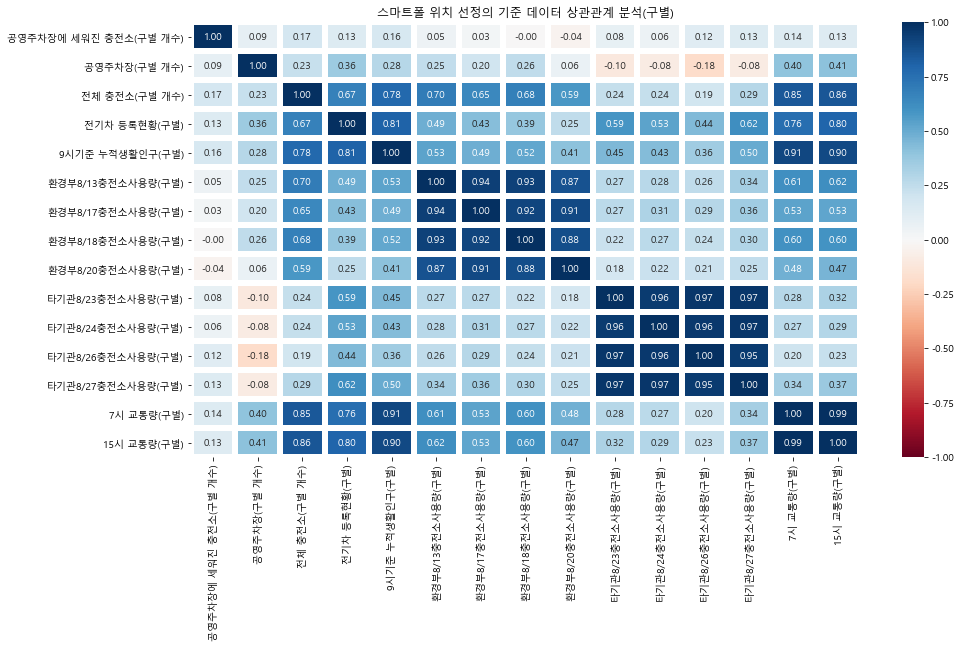

In [32]:
# 피어슨 상관계수 히트맵 그리기 => 파란색이 짙을수록 상관관계 높고 빨간색이 진할수록 낮음
plt.figure(figsize=(15,8))
plt.title('스마트폴 위치 선정의 기준 데이터 상관관계 분석(구별)')
sns.heatmap(data=vs.corr(),annot=True,fmt='.2f',linewidths=5,cmap='RdBu',vmin=-1,vmax=1,center=0)

# 동별 피어슨상관계수를 위한 데이터 불러오기 (이미 전처리는 되어있다.)

In [33]:
# 동별 인구데이터
dong_people=pd.read_csv('data/동별 인구데이터.csv')
dong_people=dong_people[['동','합계']]
dong_people=dong_people.sort_values(by='동',ascending=True)
dong_people=dong_people.reset_index(drop=True)
dong_people=dong_people.append({'동':'항동','합계':0},ignore_index=True)
dong_people.head()

,동,합계
0,가락동,2217030
1,가리봉동,309644
2,가산동,2363375
3,가양동,1703136
4,가회동,49270


In [34]:
# 동별 전기차 등록 데이터
dong_car=car[['동','전기']]
dong_car=dong_car.sort_values(by='동',ascending=True)
dong_car=dong_car.reset_index(drop=True)
dong_car.head()

,동,전기
0,가락동,163.0
1,가리봉동,5.0
2,가산동,220.0
3,가양동,90.0
4,가회동,5.0


In [35]:
#동별 7시 교통량데이터
dong_traffic1=traffic1[['동','교통량']]
dong_traffic1=dong_traffic1.append({'동':'항동','교통량':0},ignore_index=True) #결측치가 발견되어 추가해준다.
dong_traffic1=dong_traffic1.sort_values(by='동',ascending=True)
dong_traffic1=dong_traffic1.reset_index(drop=True)
dong_traffic1.head()

,동,교통량
0,가락동,258886.0
1,가리봉동,37925.0
2,가산동,210345.0
3,가양동,236764.0
4,가회동,2695.0


In [36]:
#동별 15시 교통량데이터
dong_traffic2=traffic2[['동','교통량']]
dong_traffic2=dong_traffic2.append({'동':'항동','교통량':0},ignore_index=True)
dong_traffic2=dong_traffic2.sort_values(by='동',ascending=True)
dong_traffic2=dong_traffic2.reset_index(drop=True)
dong_traffic2.head()

,동,교통량
0,가락동,233350.0
1,가리봉동,33424.0
2,가산동,185044.0
3,가양동,221805.5
4,가회동,2596.5


In [37]:
#동별 전체 충전소 데이터
dong_total=pd.read_csv('data/0포함 동별 충전소개수.csv')
dong_total=dong_total[['동','개수']]
dong_total.head()

,동,개수
0,가락동,19
1,가리봉동,3
2,가산동,61
3,가양동,16
4,가회동,1


In [38]:
#동별 공영주차장 데이터
dong_park=pd.read_csv('data/0포함 동별 공영주차장 개수.csv')
dong_park=dong_park[['동','개수']]
dong_park=dong_park.sort_values(by='동',ascending=True)
dong_park=dong_park.reset_index(drop=True)
dong_park.head()

,동,개수
0,가락동,4
1,가리봉동,1
2,가산동,20
3,가양동,4
4,가회동,0


In [39]:
# 동별 공영주차장 충전소 데이터
dong_already=pd.read_csv('data/공영주차장 충전소 동.csv')
dong_already=dong_already.sort_values(by='동',ascending=True)
dong_already=dong_already.reset_index(drop=True)
dong_already.head()

,동,개수
0,가락동,0
1,가리봉동,0
2,가산동,2
3,가양동,0
4,가회동,0


In [40]:
#동별 0813 크롤링데이터
h0813=pd.read_csv('data/0813 동별 사용량.csv')
h0813.head()

,동,개수
0,가락동,0
1,가리봉동,3
2,가산동,0
3,가양동,17
4,가회동,0


In [41]:
#동별 0817 크롤링데이터
h0817=pd.read_csv('data/0817 동별 사용량.csv')
h0817.head()

,동,개수
0,가락동,0
1,가리봉동,1
2,가산동,0
3,가양동,13
4,가회동,0


In [42]:
#동별 0818 크롤링데이터
h0818=pd.read_csv('data/0818 동별 사용량.csv')
h0818.head()

,동,개수
0,가락동,0
1,가리봉동,1
2,가산동,0
3,가양동,10
4,가회동,0


In [43]:
#동별 0820 크롤링데이터
h0820=pd.read_csv('data/0820 동별 사용량.csv')
h0820.head()

,동,개수
0,가락동,1
1,가리봉동,2
2,가산동,0
3,가양동,6
4,가회동,0


In [44]:
#주차면적이 50이상인 공영주차장 데이터 (100이상은 해봤으나 상관관계가 더 낮아 삭제해버림) <=법령을 참고하기위해
space50=pd.read_csv('data/주차면적50이상주차장.csv')
space50.head()

,동,개수
0,가락동,1.0
1,가리봉동,1.0
2,가산동,4.0
3,가양동,82.0
4,가회동,0.0


In [45]:
# 각 데이터들이 동별 개수인 467개와 일치하는지 확인
print(len(dong_already))
print(len(dong_park))
print(len(dong_total))
print(len(dong_car))
print(len(dong_people))
print(len(h0813))
print(len(h0817))
print(len(h0818))
print(len(h0820))
print(len(space50))
print(len(dong_traffic1))
print(len(dong_traffic2))

467
467
467
467
467
467
467
467
467
467
467
467


In [46]:
#각 데이터들 모두 동을 기준으로 가나다 정렬이 되어있기 때문에 그중 하나인 환경부데이터에서 동 목록을 가져온다.
dong_list=list(h0820['동'])
dong_list

['가락동',
 '가리봉동',
 '가산동',
 '가양동',
 '가회동',
 '갈월동',
 '갈현동',
 '강일동',
 '개봉동',
 '개포동',
 '개화동',
 '거여동',
 '견지동',
 '경운동',
 '계동',
 '고덕동',
 '고척동',
 '공덕동',
 '공릉동',
 '공평동',
 '공항동',
 '과해동',
 '관수동',
 '관철동',
 '관훈동',
 '광장동',
 '광희동1가',
 '광희동2가',
 '교남동',
 '교북동',
 '구기동',
 '구로동',
 '구산동',
 '구수동',
 '구의동',
 '군자동',
 '궁동',
 '궁정동',
 '권농동',
 '금호동1가',
 '금호동2가',
 '금호동3가',
 '금호동4가',
 '길동',
 '길음동',
 '낙원동',
 '남가좌동',
 '남대문로1가',
 '남대문로2가',
 '남대문로3가',
 '남대문로4가',
 '남대문로5가',
 '남산동1가',
 '남산동2가',
 '남산동3가',
 '남영동',
 '남창동',
 '남학동',
 '남현동',
 '내곡동',
 '내발산동',
 '내수동',
 '내자동',
 '냉천동',
 '노고산동',
 '노량진동',
 '녹번동',
 '논현동',
 '누상동',
 '누하동',
 '능동',
 '다동',
 '답십리동',
 '당산동',
 '당산동1가',
 '당산동2가',
 '당산동3가',
 '당산동4가',
 '당산동5가',
 '당산동6가',
 '당인동',
 '당주동',
 '대림동',
 '대방동',
 '대신동',
 '대조동',
 '대치동',
 '대현동',
 '대흥동',
 '도곡동',
 '도렴동',
 '도림동',
 '도봉동',
 '도선동',
 '도원동',
 '도화동',
 '독산동',
 '돈암동',
 '돈의동',
 '동교동',
 '동빙고동',
 '동선동1가',
 '동선동2가',
 '동선동3가',
 '동선동4가',
 '동선동5가',
 '동소문동1가',
 '동소문동2가',
 '동소문동3가',
 '동소문동4가',
 '동소문동5가',
 '동소문동6가',
 '동소문동7가',
 '동숭동',
 '동자동',
 '

In [47]:
#동별 피어슨 상관계수를 구하기 위해 데이터프레임 만들기
vs2=pd.DataFrame({
"공영주차장에 세워진 충전소(동별 개수)":list(dong_already['개수']),
'공영주차장(동별 개수)':list(dong_park['개수']),
'50이상주차장':list(space50['개수']),
'전체 충전소(동별 개수)':list(dong_total['개수']),
'전기차 등록현황(동별)':list(dong_car['전기']),
"9시기준 누적생활인구(동별)": list(dong_people['합계']),
"환경부8/13충전소사용량(동별)":list(h0813['개수']),
"환경부8/17충전소사용량(동별)":list(h0817['개수']),
"환경부8/18충전소사용량(동별)":list(h0818['개수']),
"환경부8/20충전소사용량(동별)":list(h0820['개수']),
'7시교통량(동별)':list(dong_traffic1['교통량']),
'15시교통량(동별)':list(dong_traffic2['교통량']),   
},index=dong_list)
vs2=vs2.astype(int)
vs2

,공영주차장에 세워진 충전소(동별 개수),공영주차장(동별 개수),50이상주차장,전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부8/13충전소사용량(동별),환경부8/17충전소사용량(동별),환경부8/18충전소사용량(동별),환경부8/20충전소사용량(동별),7시교통량(동별),15시교통량(동별)
가락동,0,4,1,19,163,2217030,0,0,0,1,258886,233350
가리봉동,0,1,1,3,5,309644,3,1,1,2,37925,33424
가산동,2,20,4,61,220,2363375,0,0,0,0,210345,185044
가양동,0,4,82,16,90,1703136,17,13,10,6,236764,221805
가회동,0,0,0,1,5,49270,0,0,0,0,2695,2596
...,...,...,...,...,...,...,...,...,...,...,...,...
훈정동,0,1,0,2,24,68667,0,0,1,0,23586,22724
휘경동,5,1,1,18,0,811631,0,0,0,0,7458,7154
흑석동,2,5,88,10,28,710049,0,1,2,4,84800,84173
흥인동,0,1,0,1,40,221399,0,0,0,0,83372,75855


In [48]:
#피어슨상관계수
vs2.loc[:,("공영주차장에 세워진 충전소(동별 개수)",'공영주차장(동별 개수)','50이상주차장','전체 충전소(동별 개수)','전기차 등록현황(동별)',"9시기준 누적생활인구(동별)","환경부8/13충전소사용량(동별)",\
"환경부8/17충전소사용량(동별)","환경부8/18충전소사용량(동별)","환경부8/20충전소사용량(동별)",'7시교통량(동별)','15시교통량(동별)')].corr(method='pearson')

,공영주차장에 세워진 충전소(동별 개수),공영주차장(동별 개수),50이상주차장,전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부8/13충전소사용량(동별),환경부8/17충전소사용량(동별),환경부8/18충전소사용량(동별),환경부8/20충전소사용량(동별),7시교통량(동별),15시교통량(동별)
공영주차장에 세워진 충전소(동별 개수),1.000000,0.422879,0.199777,0.431762,0.182059,0.500781,0.274513,0.258555,0.206273,0.312266,0.437427,0.428174
공영주차장(동별 개수),0.422879,1.000000,0.568123,0.588895,0.340451,0.604069,0.385592,0.383623,0.344427,0.443267,0.674903,0.674358
50이상주차장,0.199777,0.568123,1.000000,0.210976,0.237621,0.224889,0.151013,0.151858,0.102295,0.165272,0.329542,0.331823
전체 충전소(동별 개수),0.431762,0.588895,0.210976,1.000000,0.294602,0.804769,0.495049,0.469458,0.440089,0.560327,0.815693,0.818053
전기차 등록현황(동별),0.182059,0.340451,0.237621,0.294602,1.000000,0.347646,0.180695,0.105491,0.130769,0.167571,0.378606,0.386100
9시기준 누적생활인구(동별),0.500781,0.604069,0.224889,0.804769,0.347646,1.000000,0.471359,0.453462,0.398190,0.513340,0.851532,0.849280
환경부8/13충전소사용량(동별),0.274513,0.385592,0.151013,0.495049,0.180695,0.471359,1.000000,0.919401,0.910911,0.821956,0.555047,0.557339
환경부8/17충전소사용량(동별),0.258555,0.383623,0.151858,0.469458,0.105491,0.453462,0.919401,1.000000,0.890116,0.811077,0.506450,0.509426
환경부8/18충전소사용량(동별),0.206273,0.344427,0.102295,0.440089,0.130769,0.398190,0.910911,0.890116,1.000000,0.818278,0.474274,0.474701
환경부8/20충전소사용량(동별),0.312266,0.443267,0.165272,0.560327,0.167571,0.513340,0.821956,0.811077,0.818278,1.000000,0.568797,0.563756


<AxesSubplot:title={'center':'스마트폴 위치 선정의 기준 데이터 상관관계 분석(동별)'}>

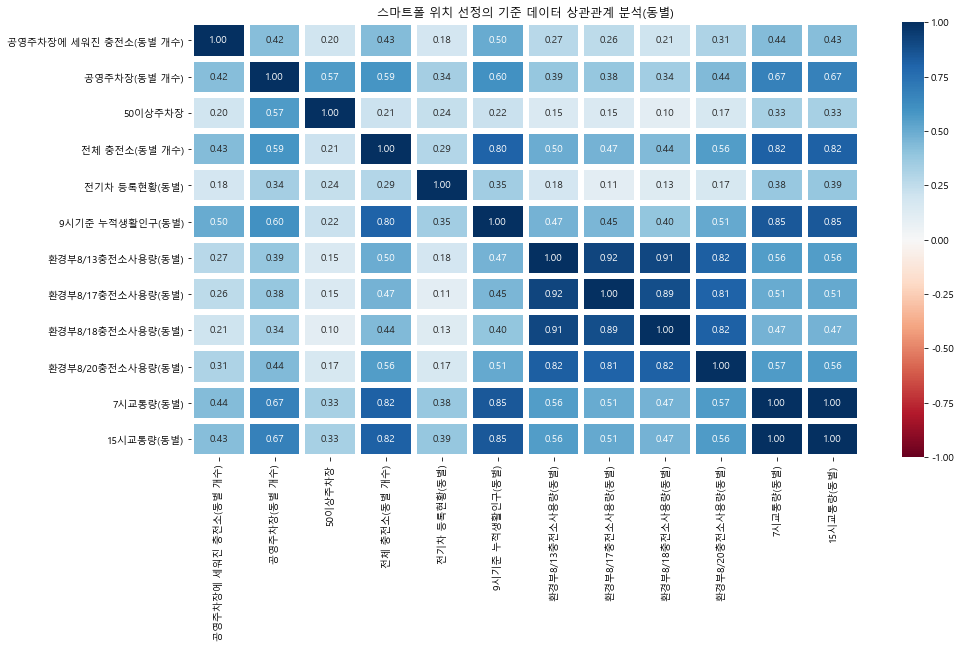

In [49]:
# 피어슨 상관계수 히트맵 => 파란색이 짙을수록 상관관계 높고 빨간색이 진할수록 낮음
plt.figure(figsize=(15,8))
plt.title('스마트폴 위치 선정의 기준 데이터 상관관계 분석(동별)')
sns.heatmap(data=vs2.corr(),annot=True,fmt='.2f',linewidths=5,cmap='RdBu',vmin=-1,vmax=1,center=0)

충전소: 0.59
인구: 0.8
사용량: 0.56
7시,15시교통량:0.82
전기차:0.29

In [50]:
# vs2.to_csv('최종데이터프레임.csv',index=False)

In [51]:
#다중공선성 확인 위한 데이터프레임 만들기
vs3=vs2[['공영주차장(동별 개수)','전기차 등록현황(동별)',"9시기준 누적생활인구(동별)",\
"환경부8/20충전소사용량(동별)",'7시교통량(동별)','15시교통량(동별)']]

In [52]:
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vs3.values, i) for i in range(vs3.shape[1])]
vif["features"] = vs3.columns
vif

,VIF Factor,features
0,2.411689,공영주차장(동별 개수)
1,1.230881,전기차 등록현황(동별)
2,0.000015,9시기준 누적생활인구(동별)
3,1.714892,환경부8/20충전소사용량(동별)
4,0.061855,7시교통량(동별)
5,0.031622,15시교통량(동별)


In [60]:
vs2.tail()

,공영주차장에 세워진 충전소(동별 개수),공영주차장(동별 개수),50이상주차장,전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부8/13충전소사용량(동별),환경부8/17충전소사용량(동별),환경부8/18충전소사용량(동별),환경부8/20충전소사용량(동별),7시교통량(동별),15시교통량(동별)
훈정동,0,1,0,2,24,68667,0,0,1,0,23586,22724
휘경동,5,1,1,18,0,811631,0,0,0,0,7458,7154
흑석동,2,5,88,10,28,710049,0,1,2,4,84800,84173
흥인동,0,1,0,1,40,221399,0,0,0,0,83372,75855
항동,0,1,0,4,1,0,0,0,0,0,15838,15466
